# 01 - Data Exploration (EDA)

## What is Exploratory Data Analysis?

**Exploratory Data Analysis (EDA)** is the critical first step in any data science project. Before building models or running analyses, you need to understand your data:

- **What does the data look like?** (shape, types, distributions)
- **Is it clean?** (missing values, outliers, errors)
- **What patterns exist?** (correlations, trends, clusters)
- **What questions can we answer?** (feasibility check)

### Why EDA Matters

| Without EDA | With EDA |
|-------------|----------|
| Build model on bad data | Catch data quality issues early |
| Misinterpret results | Understand what's actually happening |
| Waste time on wrong approach | Choose appropriate methods |
| Miss obvious insights | Find low-hanging fruit |

### What We'll Cover

1. **Database Connection** - Verify data pipeline works
2. **GDELT Events Analysis** - Understand geopolitical event data
3. **Market Data Exploration** - Understand financial time series
4. **Initial Correlations** - First look at relationships

---

## Setup and Imports

### Best Practice: Organize Imports

Professional data scientists organize imports into groups:
1. **Standard library** (sys, pathlib, datetime)
2. **Third-party packages** (pandas, numpy, matplotlib)
3. **Local project imports** (our custom modules)

This makes code readable and helps identify dependencies.

In [2]:
# =============================================================================
# STANDARD LIBRARY IMPORTS
# =============================================================================
# These come with Python - no installation needed

import sys
from pathlib import Path  # Modern way to handle file paths (better than os.path)
from datetime import date, timedelta  # For date arithmetic

# =============================================================================
# PATH SETUP
# =============================================================================
# Jupyter notebooks run from the /notebooks directory, but our code is in /src
# We need to add the project root to Python's path so imports work

project_root = Path.cwd().parent  # Go up one level from /notebooks to project root
sys.path.insert(0, str(project_root))  # Add to beginning of path

# =============================================================================
# THIRD-PARTY IMPORTS
# =============================================================================
# These need to be installed (pip install pandas numpy matplotlib seaborn)

import pandas as pd      # Data manipulation - the backbone of data science in Python
import numpy as np       # Numerical computing - fast array operations
import matplotlib.pyplot as plt  # Plotting - the classic visualization library
import seaborn as sns    # Statistical visualization - prettier plots, built on matplotlib

# =============================================================================
# VISUALIZATION SETTINGS
# =============================================================================
# Set consistent style across all plots

plt.style.use('seaborn-v0_8-whitegrid')  # Clean, professional look
sns.set_palette('husl')  # Colorblind-friendly palette

# Magic command: display plots inline in the notebook (not in separate windows)
%matplotlib inline

# Pandas display options - show more data in outputs
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 200)

print("Setup complete!")
print(f"Project root: {project_root}")
print(f"Python version: {sys.version.split()[0]}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Matplotlib is building the font cache; this may take a moment.


Setup complete!
Project root: /Users/jake/projects/geopolitical-market-tracker
Python version: 3.12.12
Pandas version: 2.3.3
NumPy version: 2.4.0


---

## 1. Database Connection & Overview

### Why Start Here?

Before any analysis, verify that:
1. Database is running and accessible
2. Data has been ingested successfully
3. Tables have reasonable row counts

### SQLAlchemy Sessions

We use **SQLAlchemy** as our ORM (Object-Relational Mapper). Key concepts:

- **Session**: A conversation with the database
- **Context Manager** (`with`): Automatically handles opening/closing connections
- **Query**: Ask the database for data

```python
# This pattern ensures the session is properly closed even if errors occur
with get_session() as session:
    # Do database operations here
    result = session.query(Model).all()
# Session automatically closed when we exit the 'with' block
```

In [14]:
# =============================================================================
# DATABASE IMPORTS
# =============================================================================
# Import our database utilities

from src.db.connection import get_session  # Session factory
from src.db.models import Event, MarketData, AnalysisResult  # ORM models

# =============================================================================
# CHECK DATABASE CONNECTION AND ROW COUNTS
# =============================================================================
# This is a simple "health check" - make sure everything is working

try:
    with get_session() as session:
        # .count() runs SELECT COUNT(*) - very fast even on large tables
        event_count = session.query(Event).count()
        market_count = session.query(MarketData).count()
        analysis_count = session.query(AnalysisResult).count()
    
    print("Database Overview")
    print("=" * 40)
    print(f"Events:           {event_count:>10,}")
    print(f"Market Data:      {market_count:>10,}")
    print(f"Analysis Results: {analysis_count:>10,}")
    print()
    
    # Sanity checks
    if event_count == 0:
        print("WARNING: No events in database!")
        print("Run the GDELT ingestion script first.")
    if market_count == 0:
        print("WARNING: No market data in database!")
        print("Run the market data ingestion script first.")
        
except Exception as e:
    print(f"ERROR: Could not connect to database: {e}")
    print("Make sure PostgreSQL is running: docker compose up -d db")

Database Overview
Events:              576,461
Market Data:           1,352
Analysis Results:          0



### Data Ingestion (Run Once)

If the database is empty (0 events, 0 market data), run the cell below to populate it.

This will:
1. **Market Data**: Fetch 60 days of prices for 33 symbols from Yahoo Finance
2. **GDELT Events**: Fetch 14 days of geopolitical events

**Note**: This may take 2-3 minutes on first run.

In [13]:
# =============================================================================
# DATA INGESTION (Run if database is empty or needs refresh)
# =============================================================================
# This cell fetches data from external sources and populates the database.
#
# Sources:
#   - Yahoo Finance: Stock prices, commodities, currencies, ETFs
#   - GDELT: Global Database of Events, Language, and Tone
#
# Set FORCE_REINGEST = True to clear and re-fetch all data
# =============================================================================

from src.ingestion import GDELTIngestion, MarketDataIngestion

FORCE_REINGEST = False  # Set to True to clear and re-fetch all data

# Check current data status
with get_session() as session:
    event_count = session.query(Event).count()
    market_count = session.query(MarketData).count()
    
    # Check if country codes are valid (not numeric like "45.")
    if event_count > 0:
        sample = session.query(Event.action_geo_country_code).filter(
            Event.action_geo_country_code.isnot(None)
        ).first()
        if sample and sample[0] and (sample[0].replace('.', '').isdigit()):
            print("⚠️  Detected invalid country codes (numeric instead of 'US', 'RU', etc.)")
            print("   This is due to a bug in the GDELT column mapping that has been fixed.")
            print("   Setting FORCE_REINGEST = True to fix the data.\n")
            FORCE_REINGEST = True

needs_ingest = event_count == 0 or market_count == 0 or FORCE_REINGEST

if needs_ingest:
    if FORCE_REINGEST and event_count > 0:
        print("Clearing existing event data for re-ingestion...")
        with get_session() as session:
            session.query(Event).delete()
            session.commit()
        print(f"  ✓ Deleted {event_count:,} events\n")
    
    print("Starting data ingestion...")
    print("=" * 60)
    
    # ─── MARKET DATA ───
    if market_count == 0 or FORCE_REINGEST:
        print("\n[1/2] Ingesting Market Data from Yahoo Finance...")
        market = MarketDataIngestion()
        market_end = date.today()
        market_start = market_end - timedelta(days=60)
        
        print(f"      Date range: {market_start} to {market_end}")
        market.ingest_all_symbols(market_start, market_end)
        print("      ✓ Market data complete!")
    else:
        print("\n[1/2] Market data already exists, skipping...")
    
    # ─── GDELT EVENTS ───
    print("\n[2/2] Ingesting GDELT Events...")
    gdelt = GDELTIngestion()
    
    for i in range(14):
        event_date = date.today() - timedelta(days=i+1)
        print(f"      Fetching {event_date}...", end=" ")
        try:
            count = gdelt.ingest_date(event_date)
            print(f"✓ ({count} events)")
        except Exception as e:
            print(f"✗ (skipped: {e})")
    
    print("\n" + "=" * 60)
    print("Data ingestion complete! Re-run the database check cell to see counts.")
else:
    print("Database already has valid data:")
    print(f"  Events: {event_count:,}")
    print(f"  Market Data: {market_count:,}")
    print("\nTo force re-ingestion, set FORCE_REINGEST = True and re-run.")

⚠️  Detected invalid country codes (numeric instead of 'US', 'RU', etc.)
   This is due to a bug in the GDELT column mapping that has been fixed.
   Setting FORCE_REINGEST = True to fix the data.

Clearing existing event data for re-ingestion...
  ✓ Deleted 576,461 events

Starting data ingestion...

[1/2] Ingesting Market Data from Yahoo Finance...
      Date range: 2025-11-10 to 2026-01-09
      ✓ Market data complete!

[2/2] Ingesting GDELT Events...
      Fetching 2026-01-08... ✓ (60041 events)
      Fetching 2026-01-07... ✓ (60209 events)
      Fetching 2026-01-06... ✓ (56953 events)
      Fetching 2026-01-05... ✓ (50860 events)
      Fetching 2026-01-04... ✓ (32610 events)
      Fetching 2026-01-03... ✓ (32684 events)
      Fetching 2026-01-02... ✓ (35855 events)
      Fetching 2026-01-01... ✓ (30335 events)
      Fetching 2025-12-31... ✓ (41933 events)
      Fetching 2025-12-30... ✓ (44039 events)
      Fetching 2025-12-29... ✓ (41538 events)
      Fetching 2025-12-28... ✓ (2697

---

## 2. GDELT Events Analysis

### What is GDELT?

**GDELT** (Global Database of Events, Language, and Tone) monitors news media worldwide and extracts structured event data. It answers: **"Who did what to whom, when, and where?"**

### Key Fields in GDELT Data

| Field | Description | Example |
|-------|-------------|--------|
| `goldstein_scale` | Conflict/cooperation score (-10 to +10) | -7.0 (military action) |
| `num_mentions` | How many articles mentioned this event | 500 |
| `avg_tone` | Sentiment of coverage (-100 to +100) | -3.5 (slightly negative) |
| `event_root_code` | CAMEO event type (01-20) | "19" (fight) |
| `actor1_country` | Country of first actor | "USA" |
| `actor2_country` | Country of second actor | "RUS" |

### Understanding Goldstein Scale

The **Goldstein Scale** is the most important field for our analysis:

```
-10 ─────────── 0 ─────────── +10
 │              │              │
 │              │              └── Maximum cooperation
 │              │                  (e.g., military alliance)
 │              │
 │              └── Neutral
 │                  (e.g., meeting, statement)
 │
 └── Maximum conflict
     (e.g., war, mass violence)
```

In [25]:
# =============================================================================
# LOAD EVENTS INTO PANDAS DATAFRAME
# =============================================================================
# We convert SQLAlchemy objects to a pandas DataFrame for easier analysis
#
# WHY DATAFRAMES?
# - Fast vectorized operations (no slow Python loops)
# - Built-in statistics (.mean(), .std(), .describe())
# - Easy grouping and aggregation (.groupby())
# - Integration with visualization libraries

from src.db.queries import get_events_by_date_range

# Define date range - let's look at the last 30 days
end_date = date.today()
start_date = end_date - timedelta(days=30)

print(f"Loading events from {start_date} to {end_date}...")

with get_session() as session:
    # Query returns SQLAlchemy objects
    events = get_events_by_date_range(session, start_date, end_date)
    
    # Convert to list of dictionaries, then to DataFrame
    # This is a common pattern: ORM objects → dict → DataFrame
    events_df = pd.DataFrame([
        {
            'date': e.event_date,
            'goldstein_scale': e.goldstein_scale,
            'num_mentions': e.num_mentions,
            'num_articles': e.num_articles,
            'avg_tone': e.avg_tone,
            'event_root_code': e.event_root_code,
            'actor1_country': e.actor1_country_code,
            'actor2_country': e.actor2_country_code,
            'action_country': e.action_geo_country_code,
        }
        for e in events
    ])

print(f"Loaded {len(events_df):,} events")
print(f"Date range: {events_df['date'].min()} to {events_df['date'].max()}")
print(f"DataFrame shape: {events_df.shape}")
print()

# Show first few rows
# .head() is your friend - always look at your data!
events_df.head()

Loading events from 2025-12-10 to 2026-01-09...
Loaded 570,353 events
Date range: 2025-12-19 to 2026-01-08
DataFrame shape: (570353, 9)



,date,goldstein_scale,num_mentions,num_articles,avg_tone,event_root_code,actor1_country,actor2_country,action_country
0,2026-01-08,-10.0,7238,6364,-5.250514,19,USA,None,US
1,2026-01-08,-10.0,6801,5316,-5.953263,19,USA,None,US
2,2026-01-08,2.8,4786,4705,-5.714418,04,USA,None,US
3,2026-01-08,1.9,4605,4488,-5.768285,04,None,USA,US
4,2026-01-08,5.2,2754,2746,-6.056059,03,USA,None,US


### Descriptive Statistics

The `.describe()` method gives you the **five-number summary** plus mean and standard deviation:

- **count**: Number of non-null values
- **mean**: Average value
- **std**: Standard deviation (spread)
- **min**: Minimum value
- **25%**: First quartile (Q1)
- **50%**: Median (Q2)
- **75%**: Third quartile (Q3)
- **max**: Maximum value

**Pro Tip**: Compare mean vs median. If they're very different, you have skewed data.

In [26]:
# =============================================================================
# DESCRIPTIVE STATISTICS
# =============================================================================
# .describe() gives us a quick statistical overview

print("Event Statistics")
print("=" * 60)
print()

# Round for readability
stats = events_df.describe().round(2)
display(stats)

print()
print("KEY OBSERVATIONS:")
print("-" * 40)

# Calculate some insights
if len(events_df) > 0:
    avg_goldstein = events_df['goldstein_scale'].mean()
    median_goldstein = events_df['goldstein_scale'].median()
    
    print(f"• Average Goldstein: {avg_goldstein:.2f} ({'conflict-leaning' if avg_goldstein < 0 else 'cooperation-leaning'})")
    print(f"• Median Goldstein: {median_goldstein:.2f}")
    
    # Skewness check
    if abs(avg_goldstein - median_goldstein) > 1:
        print(f"• Data is SKEWED (mean ≠ median)")
    
    # Coverage
    avg_mentions = events_df['num_mentions'].mean()
    max_mentions = events_df['num_mentions'].max()
    print(f"• Average media mentions: {avg_mentions:.0f}")
    print(f"• Highest media coverage: {max_mentions:,} mentions")

Event Statistics



,goldstein_scale,num_mentions,num_articles,avg_tone
count,570353.00,570353.00,570353.00,570353.00
mean,0.33,22.53,21.81,-2.23
std,4.75,84.02,79.74,4.15
min,-10.00,5.00,1.00,-35.72
25%,-2.00,6.00,6.00,-4.92
50%,1.00,10.00,10.00,-2.27
75%,3.40,13.00,12.00,0.51
max,10.00,9150.00,9110.00,20.00



KEY OBSERVATIONS:
----------------------------------------
• Average Goldstein: 0.33 (cooperation-leaning)
• Median Goldstein: 1.00
• Average media mentions: 23
• Highest media coverage: 9,150 mentions


### Visualizing Distributions

**Histograms** show the distribution of a single variable:
- **Shape**: Normal? Skewed? Bimodal?
- **Center**: Where's the bulk of data?
- **Spread**: How variable is it?
- **Outliers**: Are there extreme values?

**Why This Matters**: Distribution shape affects which statistical methods you can use.

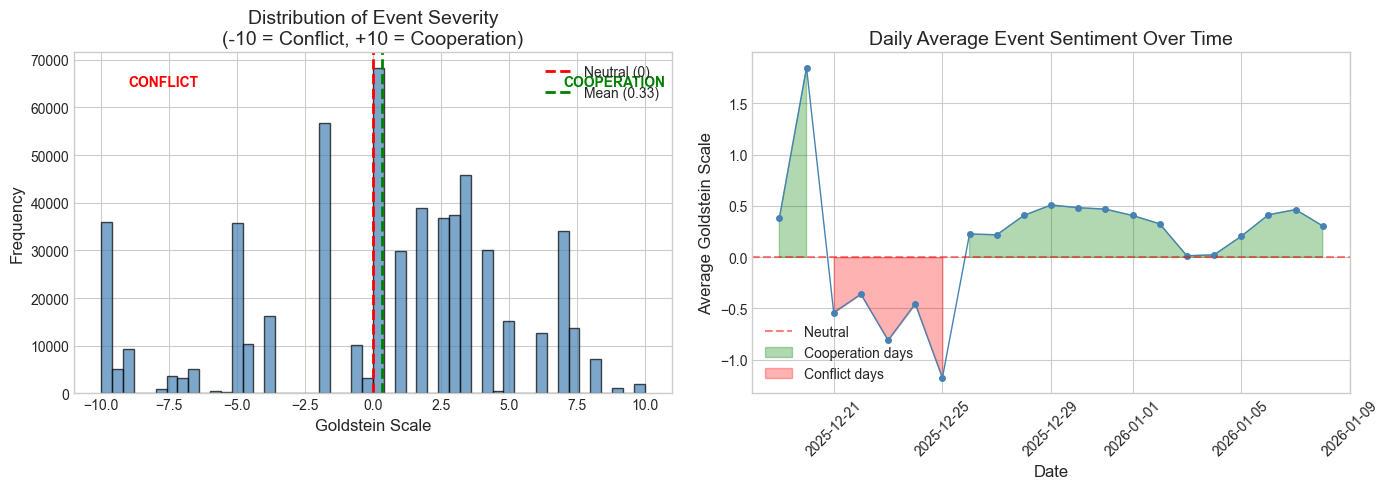


INTERPRETATION:
----------------------------------------
• 5/21 days (24%) were net conflict
• 16/21 days (76%) were net cooperation


In [27]:
# =============================================================================
# GOLDSTEIN SCALE DISTRIBUTION
# =============================================================================
# The Goldstein scale is our primary measure of event severity
# Let's understand its distribution

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# -----------------------------------------------------------------------------
# LEFT: Histogram of Goldstein scores
# -----------------------------------------------------------------------------
ax = axes[0]

# dropna() removes missing values - histograms can't handle NaN
goldstein_values = events_df['goldstein_scale'].dropna()

# bins=50 gives us good granularity; edgecolor makes bars distinguishable
ax.hist(goldstein_values, bins=50, edgecolor='black', alpha=0.7, color='steelblue')

# Reference lines help interpretation
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Neutral (0)')
ax.axvline(x=goldstein_values.mean(), color='green', linestyle='--', 
           linewidth=2, label=f'Mean ({goldstein_values.mean():.2f})')

ax.set_xlabel('Goldstein Scale', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Event Severity\n(-10 = Conflict, +10 = Cooperation)', fontsize=14)
ax.legend()

# Add text annotation explaining the scale
ax.text(-9, ax.get_ylim()[1]*0.9, 'CONFLICT', fontsize=10, color='red', fontweight='bold')
ax.text(7, ax.get_ylim()[1]*0.9, 'COOPERATION', fontsize=10, color='green', fontweight='bold')

# -----------------------------------------------------------------------------
# RIGHT: Daily average over time
# -----------------------------------------------------------------------------
ax = axes[1]

# Group by date and calculate mean Goldstein
# This shows the "mood" of global events each day
daily_goldstein = events_df.groupby('date')['goldstein_scale'].mean()

ax.plot(daily_goldstein.index, daily_goldstein.values, 
        marker='o', markersize=4, linewidth=1, color='steelblue')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Neutral')

# Fill above/below zero to show conflict vs cooperation periods
ax.fill_between(daily_goldstein.index, daily_goldstein.values, 0,
                where=(daily_goldstein.values >= 0), 
                color='green', alpha=0.3, label='Cooperation days')
ax.fill_between(daily_goldstein.index, daily_goldstein.values, 0,
                where=(daily_goldstein.values < 0),
                color='red', alpha=0.3, label='Conflict days')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Average Goldstein Scale', fontsize=12)
ax.set_title('Daily Average Event Sentiment Over Time', fontsize=14)
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='lower left')

plt.tight_layout()
plt.show()

# Print interpretation
print("\nINTERPRETATION:")
print("-" * 40)
conflict_days = (daily_goldstein < 0).sum()
total_days = len(daily_goldstein)
print(f"• {conflict_days}/{total_days} days ({conflict_days/total_days*100:.0f}%) were net conflict")
print(f"• {total_days - conflict_days}/{total_days} days ({(total_days-conflict_days)/total_days*100:.0f}%) were net cooperation")

### CAMEO Event Codes

GDELT uses **CAMEO** (Conflict and Mediation Event Observations) codes to categorize events:

| Code | Category | Examples |
|------|----------|----------|
| 01-05 | Verbal Cooperation | Statements, appeals, consultations |
| 06-09 | Material Cooperation | Aid, yielding, investigations |
| 10-14 | Verbal Conflict | Demands, disapproval, threats |
| 15-20 | Material Conflict | Force, coercion, assault, war |

**Key Insight**: Codes 18-20 (assault, fight, mass violence) are what typically move markets.

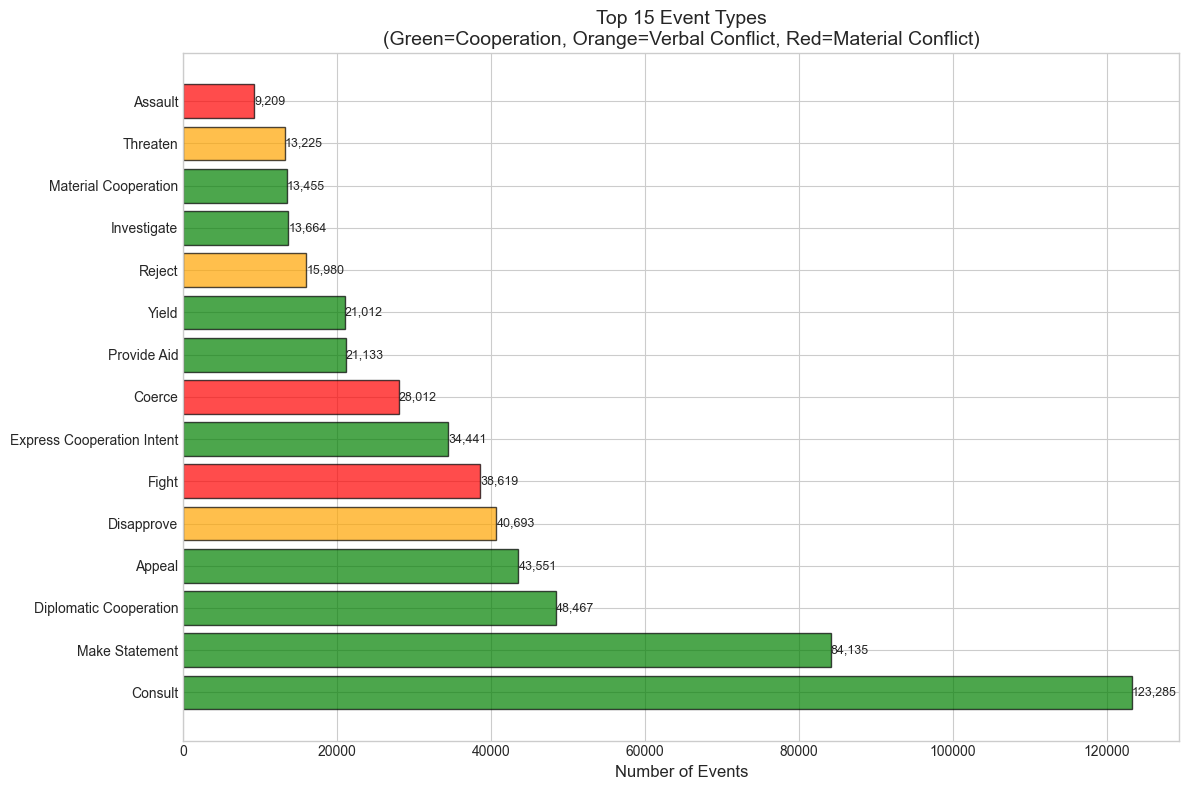


EVENT TYPE SUMMARY:
----------------------------------------
• cooperation: 403,143 events (70.7%)
• material_conflict: 83,939 events (14.7%)
• verbal_conflict: 83,271 events (14.6%)


In [28]:
# =============================================================================
# EVENT TYPE DISTRIBUTION
# =============================================================================
# Let's see what types of events dominate our data

# CAMEO root code mapping - what each code means
event_type_map = {
    '01': 'Make Statement',
    '02': 'Appeal',
    '03': 'Express Cooperation Intent',
    '04': 'Consult',
    '05': 'Diplomatic Cooperation',
    '06': 'Material Cooperation',
    '07': 'Provide Aid',
    '08': 'Yield',
    '09': 'Investigate',
    '10': 'Demand',
    '11': 'Disapprove',
    '12': 'Reject',
    '13': 'Threaten',
    '14': 'Protest',
    '15': 'Exhibit Force',
    '16': 'Reduce Relations',
    '17': 'Coerce',
    '18': 'Assault',
    '19': 'Fight',
    '20': 'Mass Violence',
}

# Count events by type
# value_counts() is like SQL's GROUP BY + COUNT
event_counts = events_df['event_root_code'].value_counts().head(15)

# Map codes to readable names
event_labels = [event_type_map.get(str(code), str(code)) for code in event_counts.index]

# Create horizontal bar chart (easier to read labels)
fig, ax = plt.subplots(figsize=(12, 8))

# Color by conflict (red) vs cooperation (green)
# Codes 01-09 are cooperation, 10-20 are conflict
colors = []
for code in event_counts.index:
    try:
        code_num = int(code)
        colors.append('green' if code_num <= 9 else 'orange' if code_num <= 14 else 'red')
    except:
        colors.append('gray')

bars = ax.barh(event_labels, event_counts.values, color=colors, alpha=0.7, edgecolor='black')

ax.set_xlabel('Number of Events', fontsize=12)
ax.set_title('Top 15 Event Types\n(Green=Cooperation, Orange=Verbal Conflict, Red=Material Conflict)', fontsize=14)

# Add count labels on bars
for bar, count in zip(bars, event_counts.values):
    ax.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2,
            f'{count:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nEVENT TYPE SUMMARY:")
print("-" * 40)

# Calculate percentages by category
def categorize_code(code):
    try:
        c = int(code)
        if c <= 9: return 'cooperation'
        elif c <= 14: return 'verbal_conflict'
        else: return 'material_conflict'
    except:
        return 'unknown'

events_df['event_category'] = events_df['event_root_code'].apply(categorize_code)
category_counts = events_df['event_category'].value_counts()

for cat, count in category_counts.items():
    pct = count / len(events_df) * 100
    print(f"• {cat}: {count:,} events ({pct:.1f}%)")

### Geographic Analysis

Understanding **where** events happen helps us map them to relevant markets:

- Events in **Russia** → RUB, natural gas, wheat
- Events in **Middle East** → Oil (CL=F)
- Events in **China** → FXI ETF, copper, global trade
- Events in **USA** → SPY, USD, treasuries

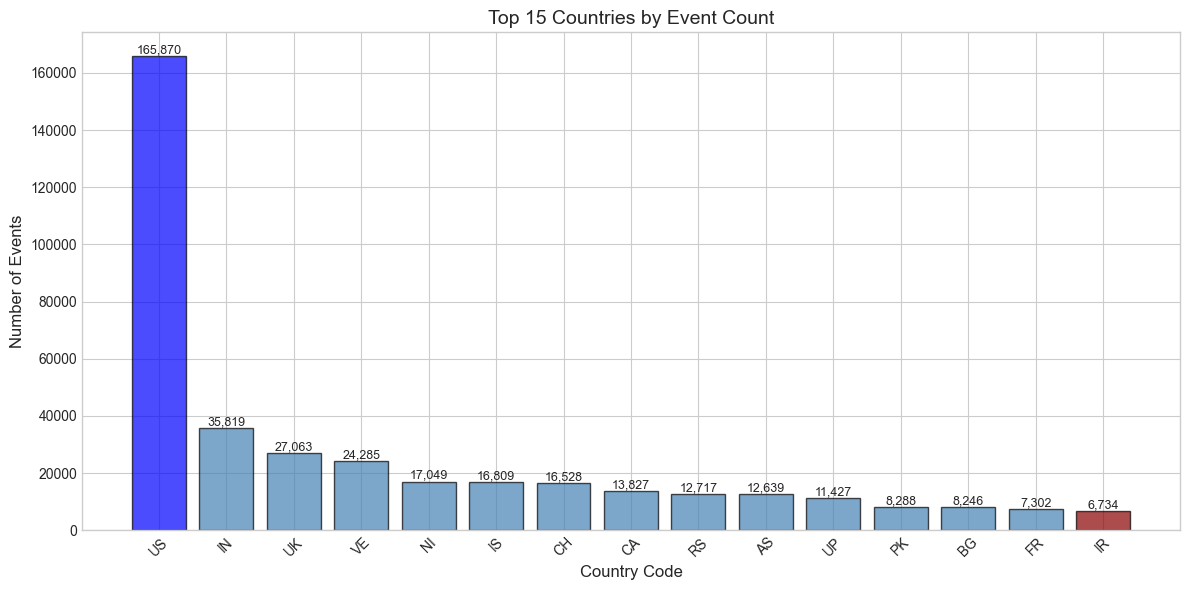


COUNTRY CODE REFERENCE:
----------------------------------------
US=United States, RU=Russia, CN=China, IR=Iran, SA=Saudi Arabia
UK=United Kingdom, UA=Ukraine, SY=Syria, IS=Israel, etc.


In [29]:
# =============================================================================
# GEOGRAPHIC DISTRIBUTION
# =============================================================================
# Which countries generate the most events?

country_counts = events_df['action_country'].value_counts().head(15)

fig, ax = plt.subplots(figsize=(12, 6))

# Color key countries differently
key_countries = {'US': 'blue', 'RU': 'red', 'CN': 'orange', 'IR': 'darkred', 'SA': 'green'}
colors = [key_countries.get(c, 'steelblue') for c in country_counts.index]

bars = ax.bar(country_counts.index, country_counts.values, 
              color=colors, alpha=0.7, edgecolor='black')

ax.set_xlabel('Country Code', fontsize=12)
ax.set_ylabel('Number of Events', fontsize=12)
ax.set_title('Top 15 Countries by Event Count', fontsize=14)
ax.tick_params(axis='x', rotation=45)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\nCOUNTRY CODE REFERENCE:")
print("-" * 40)
print("US=United States, RU=Russia, CN=China, IR=Iran, SA=Saudi Arabia")
print("UK=United Kingdom, UA=Ukraine, SY=Syria, IS=Israel, etc.")

---

## 3. Market Data Exploration

### Financial Time Series Basics

Financial data has unique characteristics:

1. **Non-stationary prices**: Prices trend over time (can't use simple statistics)
2. **Stationary returns**: Price *changes* are more stable (use these for analysis)
3. **Volatility clustering**: Big moves follow big moves
4. **Fat tails**: Extreme events happen more often than normal distribution predicts

### Why We Use Log Returns

**Log return** = ln(price_today / price_yesterday)

Advantages:
- **Additive**: Weekly return = sum of daily returns
- **Symmetric**: +10% and -10% are equal magnitude
- **More normal**: Better statistical properties

In [30]:
# =============================================================================
# LOAD MARKET DATA
# =============================================================================

from src.db.queries import get_market_data
from src.config.constants import get_all_symbols

# See what symbols we track
symbols = get_all_symbols()
print(f"Tracking {len(symbols)} symbols:")
print(symbols)
print()

# Load data for key symbols across different asset classes
key_symbols = {
    'SPY': 'S&P 500 ETF (US Stocks)',
    'CL=F': 'Crude Oil Futures',
    'GC=F': 'Gold Futures',
    '^VIX': 'Volatility Index (Fear Gauge)',
}

market_dfs = {}

with get_session() as session:
    for symbol, description in key_symbols.items():
        data = get_market_data(session, symbol, start_date, end_date)
        if data:
            df = pd.DataFrame([
                {
                    'date': d.date,
                    'close': float(d.close),
                    'log_return': d.log_return,
                    'volume': d.volume,
                }
                for d in data
            ])
            market_dfs[symbol] = df
            print(f"{symbol} ({description}): {len(df)} trading days")

print(f"\nLoaded data for {len(market_dfs)} symbols")

Tracking 33 symbols:
['CL=F', 'BZ=F', 'GC=F', 'SI=F', 'NG=F', 'ZW=F', 'ZC=F', 'ZS=F', 'EURUSD=X', 'USDJPY=X', 'GBPUSD=X', 'USDCNY=X', 'USDRUB=X', 'USDINR=X', 'USDBRL=X', 'SPY', 'QQQ', 'EEM', 'VWO', 'EWZ', 'EWJ', 'FXI', 'EWG', 'EWT', 'EWY', 'INDA', 'XLE', 'XLF', 'GDX', '^VIX', 'TLT', 'IEF', 'HYG']

SPY (S&P 500 ETF (US Stocks)): 21 trading days
CL=F (Crude Oil Futures): 21 trading days
GC=F (Gold Futures): 21 trading days
^VIX (Volatility Index (Fear Gauge)): 21 trading days

Loaded data for 4 symbols


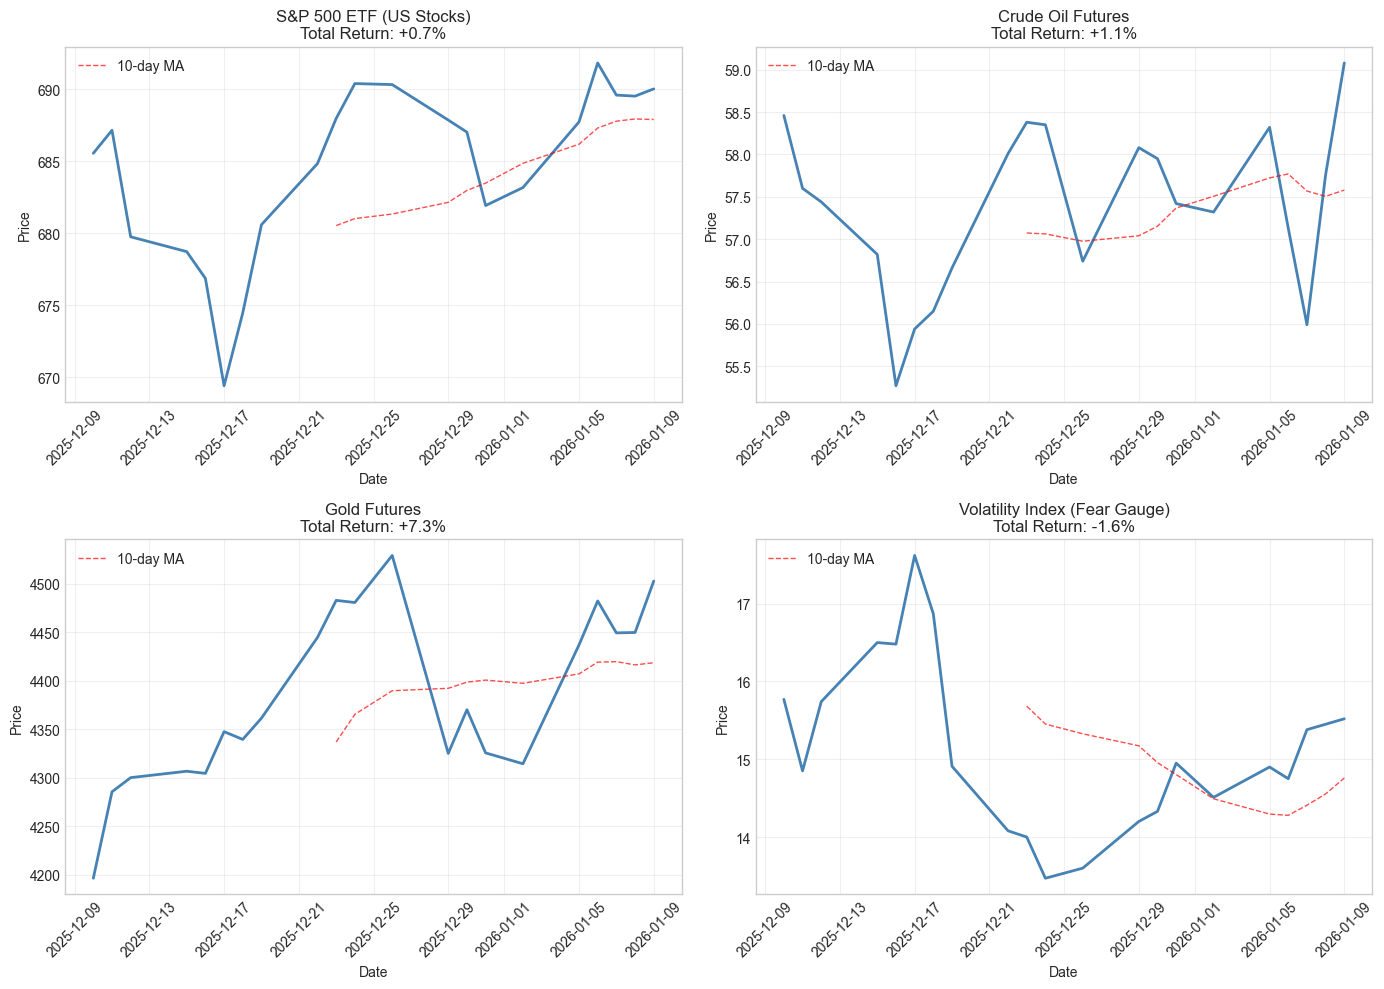

In [31]:
# =============================================================================
# PRICE CHARTS
# =============================================================================
# Visualize price movements over our analysis period

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (symbol, description) in enumerate(key_symbols.items()):
    if symbol in market_dfs and i < len(axes):
        ax = axes[i]
        df = market_dfs[symbol]
        
        # Plot price
        ax.plot(df['date'], df['close'], linewidth=2, color='steelblue')
        
        # Add moving average (shows trend)
        if len(df) >= 10:
            ma = df['close'].rolling(window=10).mean()
            ax.plot(df['date'], ma, linewidth=1, color='red', 
                    linestyle='--', alpha=0.7, label='10-day MA')
        
        # Calculate total return for title
        total_return = (df['close'].iloc[-1] / df['close'].iloc[0] - 1) * 100
        
        ax.set_title(f"{description}\nTotal Return: {total_return:+.1f}%", fontsize=12)
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.tick_params(axis='x', rotation=45)
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Return Distributions

Financial returns have distinctive properties:

1. **Centered near zero**: Most days have small moves
2. **Fat tails**: More extreme moves than normal distribution predicts
3. **Slight negative skew**: Crashes are bigger than rallies (for stocks)
4. **Excess kurtosis**: "Peaked" distribution with fat tails

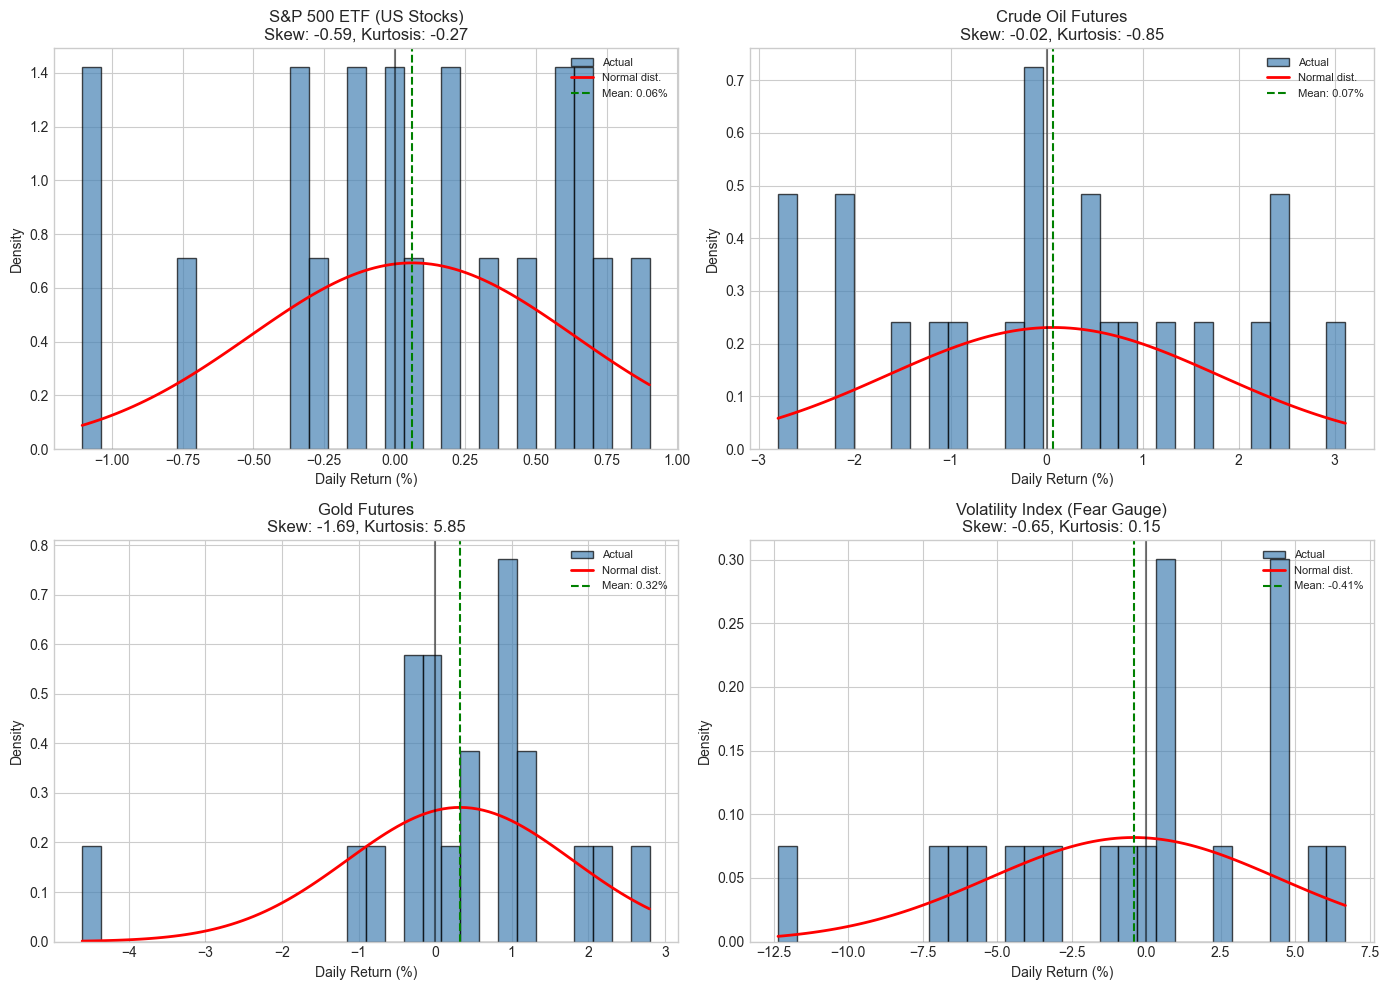


INTERPRETING SKEW AND KURTOSIS:
--------------------------------------------------
SKEWNESS (asymmetry):
  • = 0: Symmetric
  • < 0: Left tail longer (more crashes)
  • > 0: Right tail longer (more spikes)

KURTOSIS (tail thickness):
  • = 0: Normal distribution tails
  • > 0: Fatter tails (more extreme events than normal)
  • < 0: Thinner tails (fewer extreme events)


In [32]:
# =============================================================================
# RETURN DISTRIBUTIONS
# =============================================================================
# Compare return distributions across assets

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (symbol, description) in enumerate(key_symbols.items()):
    if symbol in market_dfs and i < len(axes):
        ax = axes[i]
        df = market_dfs[symbol]
        
        # Convert to percentage returns
        returns = df['log_return'].dropna() * 100
        
        if len(returns) > 0:
            # Histogram with density (normalized)
            ax.hist(returns, bins=30, edgecolor='black', alpha=0.7, 
                    density=True, color='steelblue', label='Actual')
            
            # Overlay normal distribution for comparison
            from scipy import stats
            x = np.linspace(returns.min(), returns.max(), 100)
            normal_dist = stats.norm.pdf(x, returns.mean(), returns.std())
            ax.plot(x, normal_dist, 'r-', linewidth=2, label='Normal dist.')
            
            # Reference lines
            ax.axvline(x=0, color='black', linestyle='-', alpha=0.5)
            ax.axvline(x=returns.mean(), color='green', linestyle='--', 
                       label=f'Mean: {returns.mean():.2f}%')
            
            # Statistics
            skew = returns.skew()
            kurt = returns.kurtosis()
            
            ax.set_title(f"{description}\nSkew: {skew:.2f}, Kurtosis: {kurt:.2f}", fontsize=12)
            ax.set_xlabel('Daily Return (%)')
            ax.set_ylabel('Density')
            ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

print("\nINTERPRETING SKEW AND KURTOSIS:")
print("-" * 50)
print("SKEWNESS (asymmetry):")
print("  • = 0: Symmetric")
print("  • < 0: Left tail longer (more crashes)")
print("  • > 0: Right tail longer (more spikes)")
print()
print("KURTOSIS (tail thickness):")
print("  • = 0: Normal distribution tails")
print("  • > 0: Fatter tails (more extreme events than normal)")
print("  • < 0: Thinner tails (fewer extreme events)")

---

## 4. Initial Event-Market Correlations

### Correlation Analysis

**Correlation** measures the linear relationship between two variables:

- **r = +1**: Perfect positive correlation (move together)
- **r = 0**: No linear correlation
- **r = -1**: Perfect negative correlation (move opposite)

**Important Caveat**: Correlation ≠ Causation!

Just because events and returns are correlated doesn't mean events *cause* returns. There could be:
- Reverse causation (market moves cause news coverage)
- Confounding variables (something else causes both)
- Coincidence

In [33]:
# =============================================================================
# AGGREGATE EVENTS BY DATE
# =============================================================================
# We need to summarize multiple events per day into features
# This is called "feature engineering" - creating useful inputs for analysis

# Group events by date and calculate summary statistics
daily_events = events_df.groupby('date').agg({
    'goldstein_scale': ['mean', 'min', 'max', 'std', 'count'],
    'num_mentions': 'sum',
    'avg_tone': 'mean',
}).reset_index()

# Flatten MultiIndex columns
# ('goldstein_scale', 'mean') becomes 'goldstein_mean'
daily_events.columns = [
    'date', 
    'goldstein_mean',   # Average event severity
    'goldstein_min',    # Worst event of the day
    'goldstein_max',    # Best event of the day
    'goldstein_std',    # Spread of events (high = mixed day)
    'event_count',      # Total number of events
    'total_mentions',   # Total media coverage
    'avg_tone'          # Average sentiment of coverage
]

# Fill NaN in std (happens when only one event per day)
daily_events['goldstein_std'] = daily_events['goldstein_std'].fillna(0)

print("Daily Event Features:")
print("=" * 50)
daily_events.describe().round(2)

Daily Event Features:


,goldstein_mean,goldstein_min,goldstein_max,goldstein_std,event_count,total_mentions,avg_tone
count,21.00,21.0,21.00,21.00,21.00,21.00,21.00
mean,0.16,-10.0,9.76,4.93,27159.67,611799.10,-2.52
std,0.61,0.0,0.62,0.37,21574.66,488304.41,0.63
min,-1.18,-10.0,8.00,4.33,102.00,1871.00,-4.53
25%,0.01,-10.0,10.00,4.72,157.00,4193.00,-2.79
50%,0.30,-10.0,10.00,4.75,32232.00,703467.00,-2.25
75%,0.41,-10.0,10.00,5.02,41830.00,915188.00,-2.10
max,1.85,-10.0,10.00,5.61,58917.00,1393808.00,-1.91


In [34]:
# =============================================================================
# MERGE EVENTS WITH MARKET DATA
# =============================================================================
# Join on date to create a single dataset

if 'CL=F' in market_dfs:
    oil_df = market_dfs['CL=F'].copy()
    
    # Left join: keep all market dates, fill missing events with NaN
    merged = pd.merge(oil_df, daily_events, on='date', how='left')
    
    # Fill NaN event data with zeros (days with no events)
    event_cols = ['goldstein_mean', 'goldstein_min', 'goldstein_max', 
                  'goldstein_std', 'event_count', 'total_mentions', 'avg_tone']
    merged[event_cols] = merged[event_cols].fillna(0)
    
    # Remove rows with missing returns
    merged = merged.dropna(subset=['log_return'])
    
    print(f"Merged dataset: {len(merged)} rows")
    print(f"Columns: {list(merged.columns)}")
    print()
    merged.head()

Merged dataset: 21 rows
Columns: ['date', 'close', 'log_return', 'volume', 'goldstein_mean', 'goldstein_min', 'goldstein_max', 'goldstein_std', 'event_count', 'total_mentions', 'avg_tone']



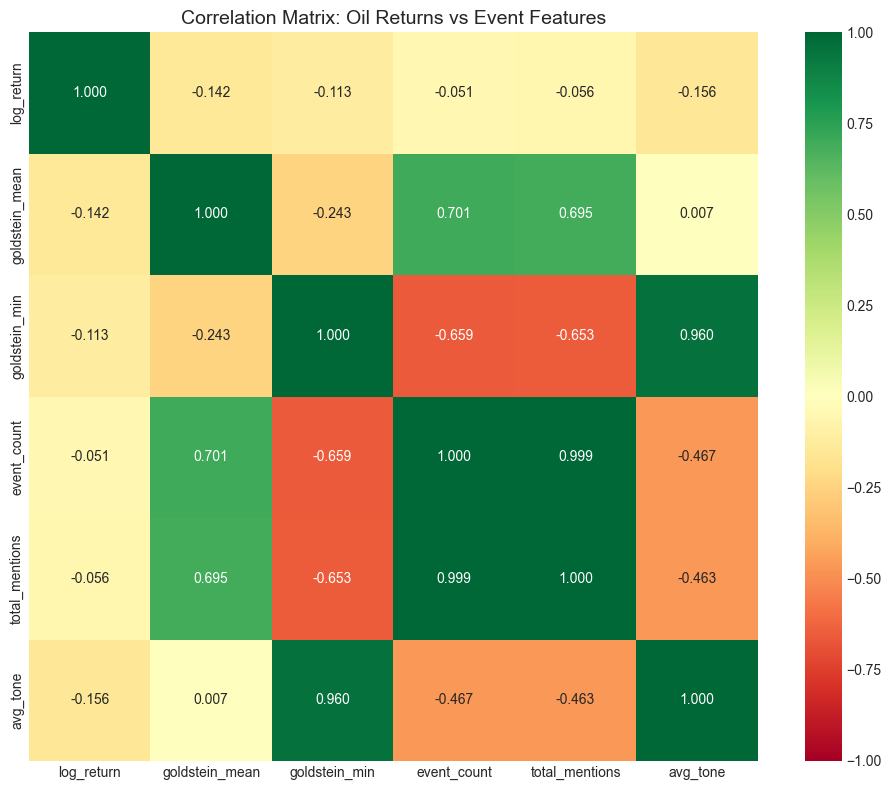


CORRELATIONS WITH OIL RETURNS:
--------------------------------------------------
• avg_tone: r = -0.156 (moderate negative)
• goldstein_mean: r = -0.142 (moderate negative)
• goldstein_min: r = -0.113 (moderate negative)
• total_mentions: r = -0.056 (weak negative)
• event_count: r = -0.051 (weak negative)


In [35]:
# =============================================================================
# CORRELATION MATRIX
# =============================================================================
# Calculate pairwise correlations between all numeric columns

if 'merged' in dir() and len(merged) > 10:
    # Select columns for correlation
    corr_cols = ['log_return', 'goldstein_mean', 'goldstein_min', 
                 'event_count', 'total_mentions', 'avg_tone']
    
    # Calculate correlation matrix
    corr_matrix = merged[corr_cols].corr()
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Use diverging colormap centered at 0
    sns.heatmap(corr_matrix, 
                annot=True,          # Show correlation values
                fmt='.3f',           # 3 decimal places
                cmap='RdYlGn',       # Red (negative) - Yellow (zero) - Green (positive)
                center=0,            # Center colormap at 0
                vmin=-1, vmax=1,     # Correlation ranges -1 to 1
                square=True,         # Square cells
                ax=ax)
    
    ax.set_title('Correlation Matrix: Oil Returns vs Event Features', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Interpret correlations with returns
    print("\nCORRELATIONS WITH OIL RETURNS:")
    print("-" * 50)
    return_corrs = corr_matrix['log_return'].drop('log_return').sort_values(key=abs, ascending=False)
    
    for feature, corr in return_corrs.items():
        strength = 'weak' if abs(corr) < 0.1 else 'moderate' if abs(corr) < 0.3 else 'strong'
        direction = 'positive' if corr > 0 else 'negative'
        print(f"• {feature}: r = {corr:.3f} ({strength} {direction})")
else:
    print("Insufficient data for correlation analysis.")
    print("Run the data ingestion scripts first.")

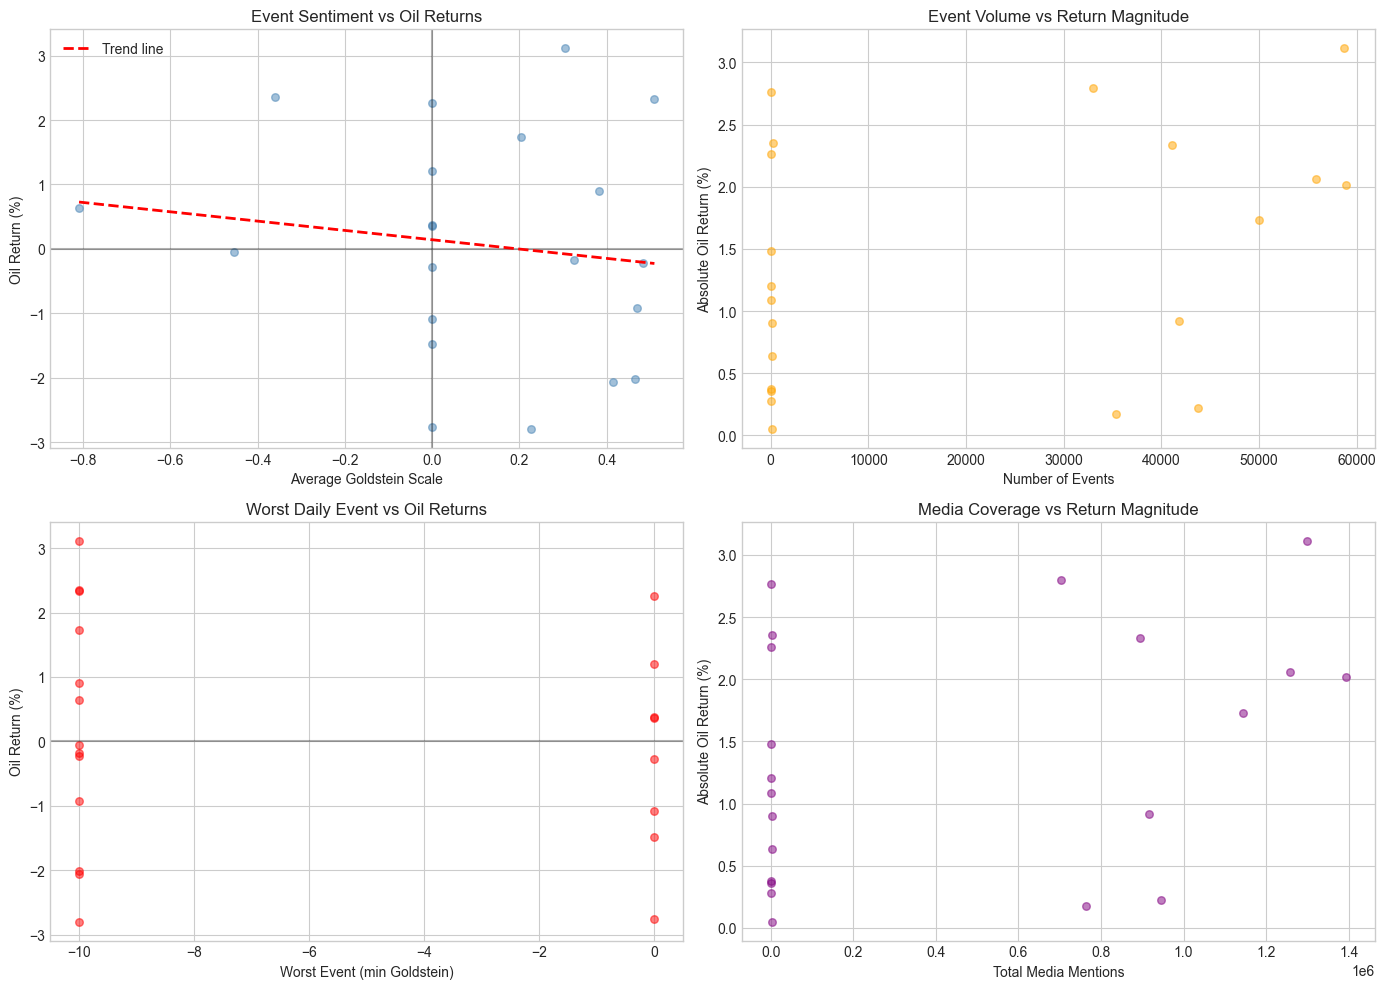


INTERPRETATION GUIDE:
--------------------------------------------------
• Scatter with clear trend → Potential predictive relationship
• Cloud with no pattern → Weak or no relationship
• Funnel shape → Relationship depends on another variable


In [36]:
# =============================================================================
# SCATTER PLOTS
# =============================================================================
# Visualize relationships between events and returns

if 'merged' in dir() and len(merged) > 10:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Goldstein mean vs return
    ax = axes[0, 0]
    ax.scatter(merged['goldstein_mean'], merged['log_return'] * 100, 
               alpha=0.5, s=30, color='steelblue')
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Add trend line
    z = np.polyfit(merged['goldstein_mean'], merged['log_return'] * 100, 1)
    p = np.poly1d(z)
    x_line = np.linspace(merged['goldstein_mean'].min(), merged['goldstein_mean'].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', linewidth=2, label='Trend line')
    
    ax.set_xlabel('Average Goldstein Scale')
    ax.set_ylabel('Oil Return (%)')
    ax.set_title('Event Sentiment vs Oil Returns')
    ax.legend()
    
    # 2. Event count vs absolute return
    ax = axes[0, 1]
    ax.scatter(merged['event_count'], merged['log_return'].abs() * 100,
               alpha=0.5, s=30, color='orange')
    ax.set_xlabel('Number of Events')
    ax.set_ylabel('Absolute Oil Return (%)')
    ax.set_title('Event Volume vs Return Magnitude')
    
    # 3. Worst event vs return
    ax = axes[1, 0]
    ax.scatter(merged['goldstein_min'], merged['log_return'] * 100,
               alpha=0.5, s=30, color='red')
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax.set_xlabel('Worst Event (min Goldstein)')
    ax.set_ylabel('Oil Return (%)')
    ax.set_title('Worst Daily Event vs Oil Returns')
    
    # 4. Media coverage vs absolute return
    ax = axes[1, 1]
    ax.scatter(merged['total_mentions'], merged['log_return'].abs() * 100,
               alpha=0.5, s=30, color='purple')
    ax.set_xlabel('Total Media Mentions')
    ax.set_ylabel('Absolute Oil Return (%)')
    ax.set_title('Media Coverage vs Return Magnitude')
    
    plt.tight_layout()
    plt.show()
    
    print("\nINTERPRETATION GUIDE:")
    print("-" * 50)
    print("• Scatter with clear trend → Potential predictive relationship")
    print("• Cloud with no pattern → Weak or no relationship")
    print("• Funnel shape → Relationship depends on another variable")

---

## Summary & Next Steps

### What We Learned

| Topic | Key Findings |
|-------|-------------|
| **GDELT Events** | Goldstein scale measures conflict/cooperation; verbal events dominate |
| **Market Data** | Returns are approximately normal with fat tails; VIX spikes during stress |
| **Correlations** | Event features show weak-to-moderate correlation with returns |

### Why Correlations Are Weak

Don't be discouraged by low correlations! This is expected because:

1. **Markets are efficient**: Information is priced in quickly
2. **Many factors matter**: Events are just one input among many
3. **Aggregation loses signal**: Daily averages mask individual event impacts
4. **Timing matters**: Same-day analysis misses lead/lag relationships

### Next Notebooks

| Notebook | Analysis | Question Answered |
|----------|----------|------------------|
| `02_event_study_demo.ipynb` | Event Study | Did *this specific event* move the market? |
| `03_anomaly_detection.ipynb` | Anomaly Detection | What unusual patterns exist in event-market relationships? |
| `04_classification_demo.ipynb` | Classification | Can we predict market direction from events? |

---

### Key Data Science Skills Practiced

- **Data Loading**: SQLAlchemy ORM → Pandas DataFrames
- **Descriptive Statistics**: `.describe()`, `.value_counts()`
- **Visualization**: Histograms, bar charts, scatter plots, heatmaps
- **Feature Engineering**: Aggregating events by date
- **Correlation Analysis**: Understanding relationships between variables